In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation 
from matplotlib import colors
from celluloid import Camera
import time

In [3]:
def move(location, lattice):
    state = lattice[location]
    direction = np.random.randint(4)

    #move up, y < n - 1
    if direction == 0 and location[1] < len(lattice[0]) - 1:
        if lattice[(location[0],location[1]+1)] == 0:
            lattice[(location[0],location[1]+1)] = state
            lattice[location] = 0
    #move down, y > 0
    if direction == 1 and location[1] > 0:
        if lattice[(location[0],location[1]-1)] == 0:
            lattice[(location[0],location[1]-1)] = state
            lattice[location] = 0
    #move right, x < n - 1
    if direction == 2 and location[0] < len(lattice) - 1:
        if lattice[(location[0]+1,location[1])] == 0:
            lattice[(location[0]+1,location[1])] = state
            lattice[location] = 0
    #move left, x > 0
    if direction == 3 and location[0] > 0:
        if lattice[(location[0]-1,location[1])] == 0:
            lattice[(location[0]-1,location[1])] = state
            lattice[location] = 0

def infect(location, lattice):
    direction = np.random.randint(4)

    #infect up, y < n - 1
    if direction == 0 and location[1] < len(lattice) - 1:
        if lattice[(location[0],location[1]+1)] == 1:
            lattice[(location[0],location[1]+1)] = 2
    #infect down, y > 0
    if direction == 1 and location[1] > 0:
        if lattice[(location[0],location[1]-1)] == 1:
            lattice[(location[0],location[1]-1)] = 2
    #infect right, x < n - 1
    if direction == 2 and location[0] < len(lattice) - 1:
        if lattice[(location[0]+1,location[1])] == 1:
            lattice[(location[0]+1,location[1])] = 2
    #infect left, x > 0
    if direction == 3 and location[0] > 0:
        if lattice[(location[0]-1,location[1])] == 1:
            lattice[(location[0]-1,location[1])] = 2

def get_random_agent_location(lattice, infectedOnly=False):
    if infectedOnly:
        individuals = np.where(lattice==2)
    else:
        individuals = np.where(lattice!=0)
    
    #print(np.random.randint(len(individuals[0])))
    random_individual_index = np.random.randint(len(individuals[0]))
    location = (individuals[0][random_individual_index], individuals[1][random_individual_index])
    return location

In [4]:
def SIR_ABM(pi = 0.1, pm = 1.0, pr = 0.01, n = 20, s0 = 0.49, i0 = 0.01, r0 = 0.00, snapshot_num = 600):

    #initialise array with individuals (S = 1, I = 2, R = 3)
    #1d array with required number of individuals
    A = np.zeros((n**2))
    S_num = int(np.ceil(s0 * n**2))
    I_num = int(np.ceil(i0 * n**2))
    R_num = int(np.ceil(r0 * n**2))
    A[:S_num] = 1
    A[S_num:S_num+I_num] = 2
    A[S_num + I_num:S_num + I_num + R_num] = 3
    #shuffle and reshape to 2d
    np.random.shuffle(A)
    A = A.reshape(n,n)

    #time
    t = 0
    max_time = 5/pr

    #lists, st is list of indexes of snapshot times, so that t[st[i]] gives time of i'th snapshot of A
    t_list = [t]
    S_list = [S_num]
    I_list = [I_num]
    R_list = [R_num]
    A_list = [np.copy(A)]
    st_list = [t]

    #snapshot
    snapshot_count = 0
    count = 0

    while t < max_time:
        #decide which event takes place and advance time
        a = pm*(S_num+I_num+R_num) + pi*I_num + pr*I_num
        step = -np.log(np.random.uniform())/a
        t += step
        event = a*np.random.uniform()

        if event <= pm*(S_num+I_num+R_num):
            #movement
            loc = get_random_agent_location(A)
            move(loc, A)
        elif (pm*(S_num+I_num+R_num) < event) and  (event <= pm*(S_num+I_num+R_num) + pi*I_num):
            #infection
            loc = get_random_agent_location(A, infectedOnly=True)
            infect(loc, A)
        elif (pm*(S_num+I_num+R_num) + pi*I_num < event) and  (event <= pm*(S_num+I_num+R_num) + pi*I_num + pr*I_num):
            #recovery
            loc = get_random_agent_location(A, infectedOnly=True)
            A[loc] = 3
        
        count += 1

        S_num = np.sum(A==1)
        I_num = np.sum(A==2)
        R_num = np.sum(A==3)

        t_list.append(t)
        S_list.append(S_num)
        I_list.append(I_num)
        R_list.append(R_num)
        if t > snapshot_count*max_time/snapshot_num:
            A_list.append(np.copy(A))
            st_list.append(count)
            snapshot_count+=1

    return S_list, I_list, R_list, t_list, A_list, st_list

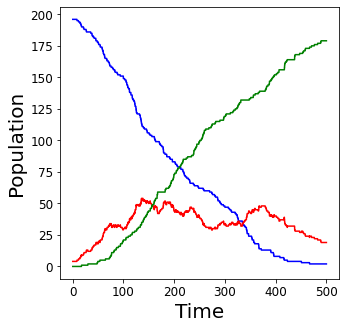

In [9]:
#plot SIR graph
S, I, R, t, A, st = SIR_ABM(n=20)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Population', fontsize=20)
ax.tick_params(axis='both', labelsize=12)
ax.plot(t[::4],S[::4], 'blue')
ax.plot(t[::4],I[::4], 'red')
ax.plot(t[::4],R[::4], 'green')

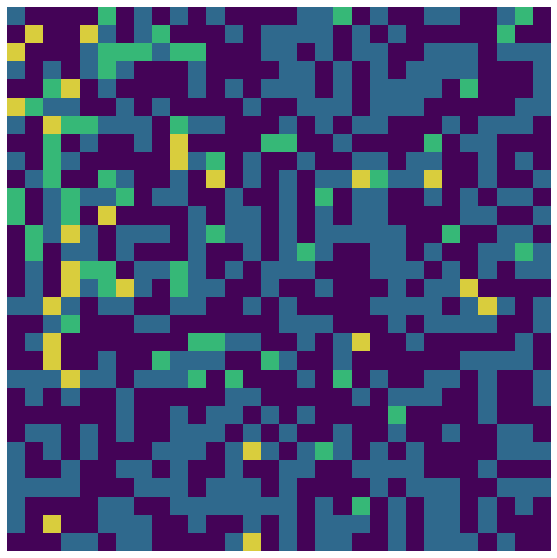

In [10]:
##anim lattice
#for large n, snapshot_num, may take a long time
A_list = SIR_ABM(n=30, snapshot_num=20)[4]
fig = plt.figure(figsize=(10,10))
plt.axis('off')
camera=Camera(fig)
for copy in A_list:
    if len(np.where(copy==3)[0])==0:
        cmap = colors.ListedColormap(['#440357','#d9cd3d','#36B877'])
    else:
        cmap = colors.ListedColormap(['#440357','#d9cd3d','#36B877','#2F698D'])
    plt.imshow(copy, cmap=cmap)
    camera.snap()

anim = camera.animate()
anim.save('test_anims/test1.mp4', fps=30)

simulating
simulated in 43.3394 seconds
plotting
plot 0 out of 62
plot 1 out of 62
plot 2 out of 62
plot 3 out of 62
plot 4 out of 62
plot 5 out of 62
plot 6 out of 62
plot 7 out of 62
plot 8 out of 62
plot 9 out of 62
plot 10 out of 62
plot 11 out of 62
plot 12 out of 62
plot 13 out of 62
plot 14 out of 62
plot 15 out of 62
plot 16 out of 62
plot 17 out of 62
plot 18 out of 62
plot 19 out of 62
plot 20 out of 62
plot 21 out of 62
plot 22 out of 62
plot 23 out of 62
plot 24 out of 62
plot 25 out of 62
plot 26 out of 62
plot 27 out of 62
plot 28 out of 62
plot 29 out of 62
plot 30 out of 62
plot 31 out of 62
plot 32 out of 62
plot 33 out of 62
plot 34 out of 62
plot 35 out of 62
plot 36 out of 62
plot 37 out of 62
plot 38 out of 62
plot 39 out of 62
plot 40 out of 62
plot 41 out of 62
plot 42 out of 62
plot 43 out of 62
plot 44 out of 62
plot 45 out of 62
plot 46 out of 62
plot 47 out of 62
plot 48 out of 62
plot 49 out of 62
plot 50 out of 62
plot 51 out of 62
plot 52 out of 62
plot 53

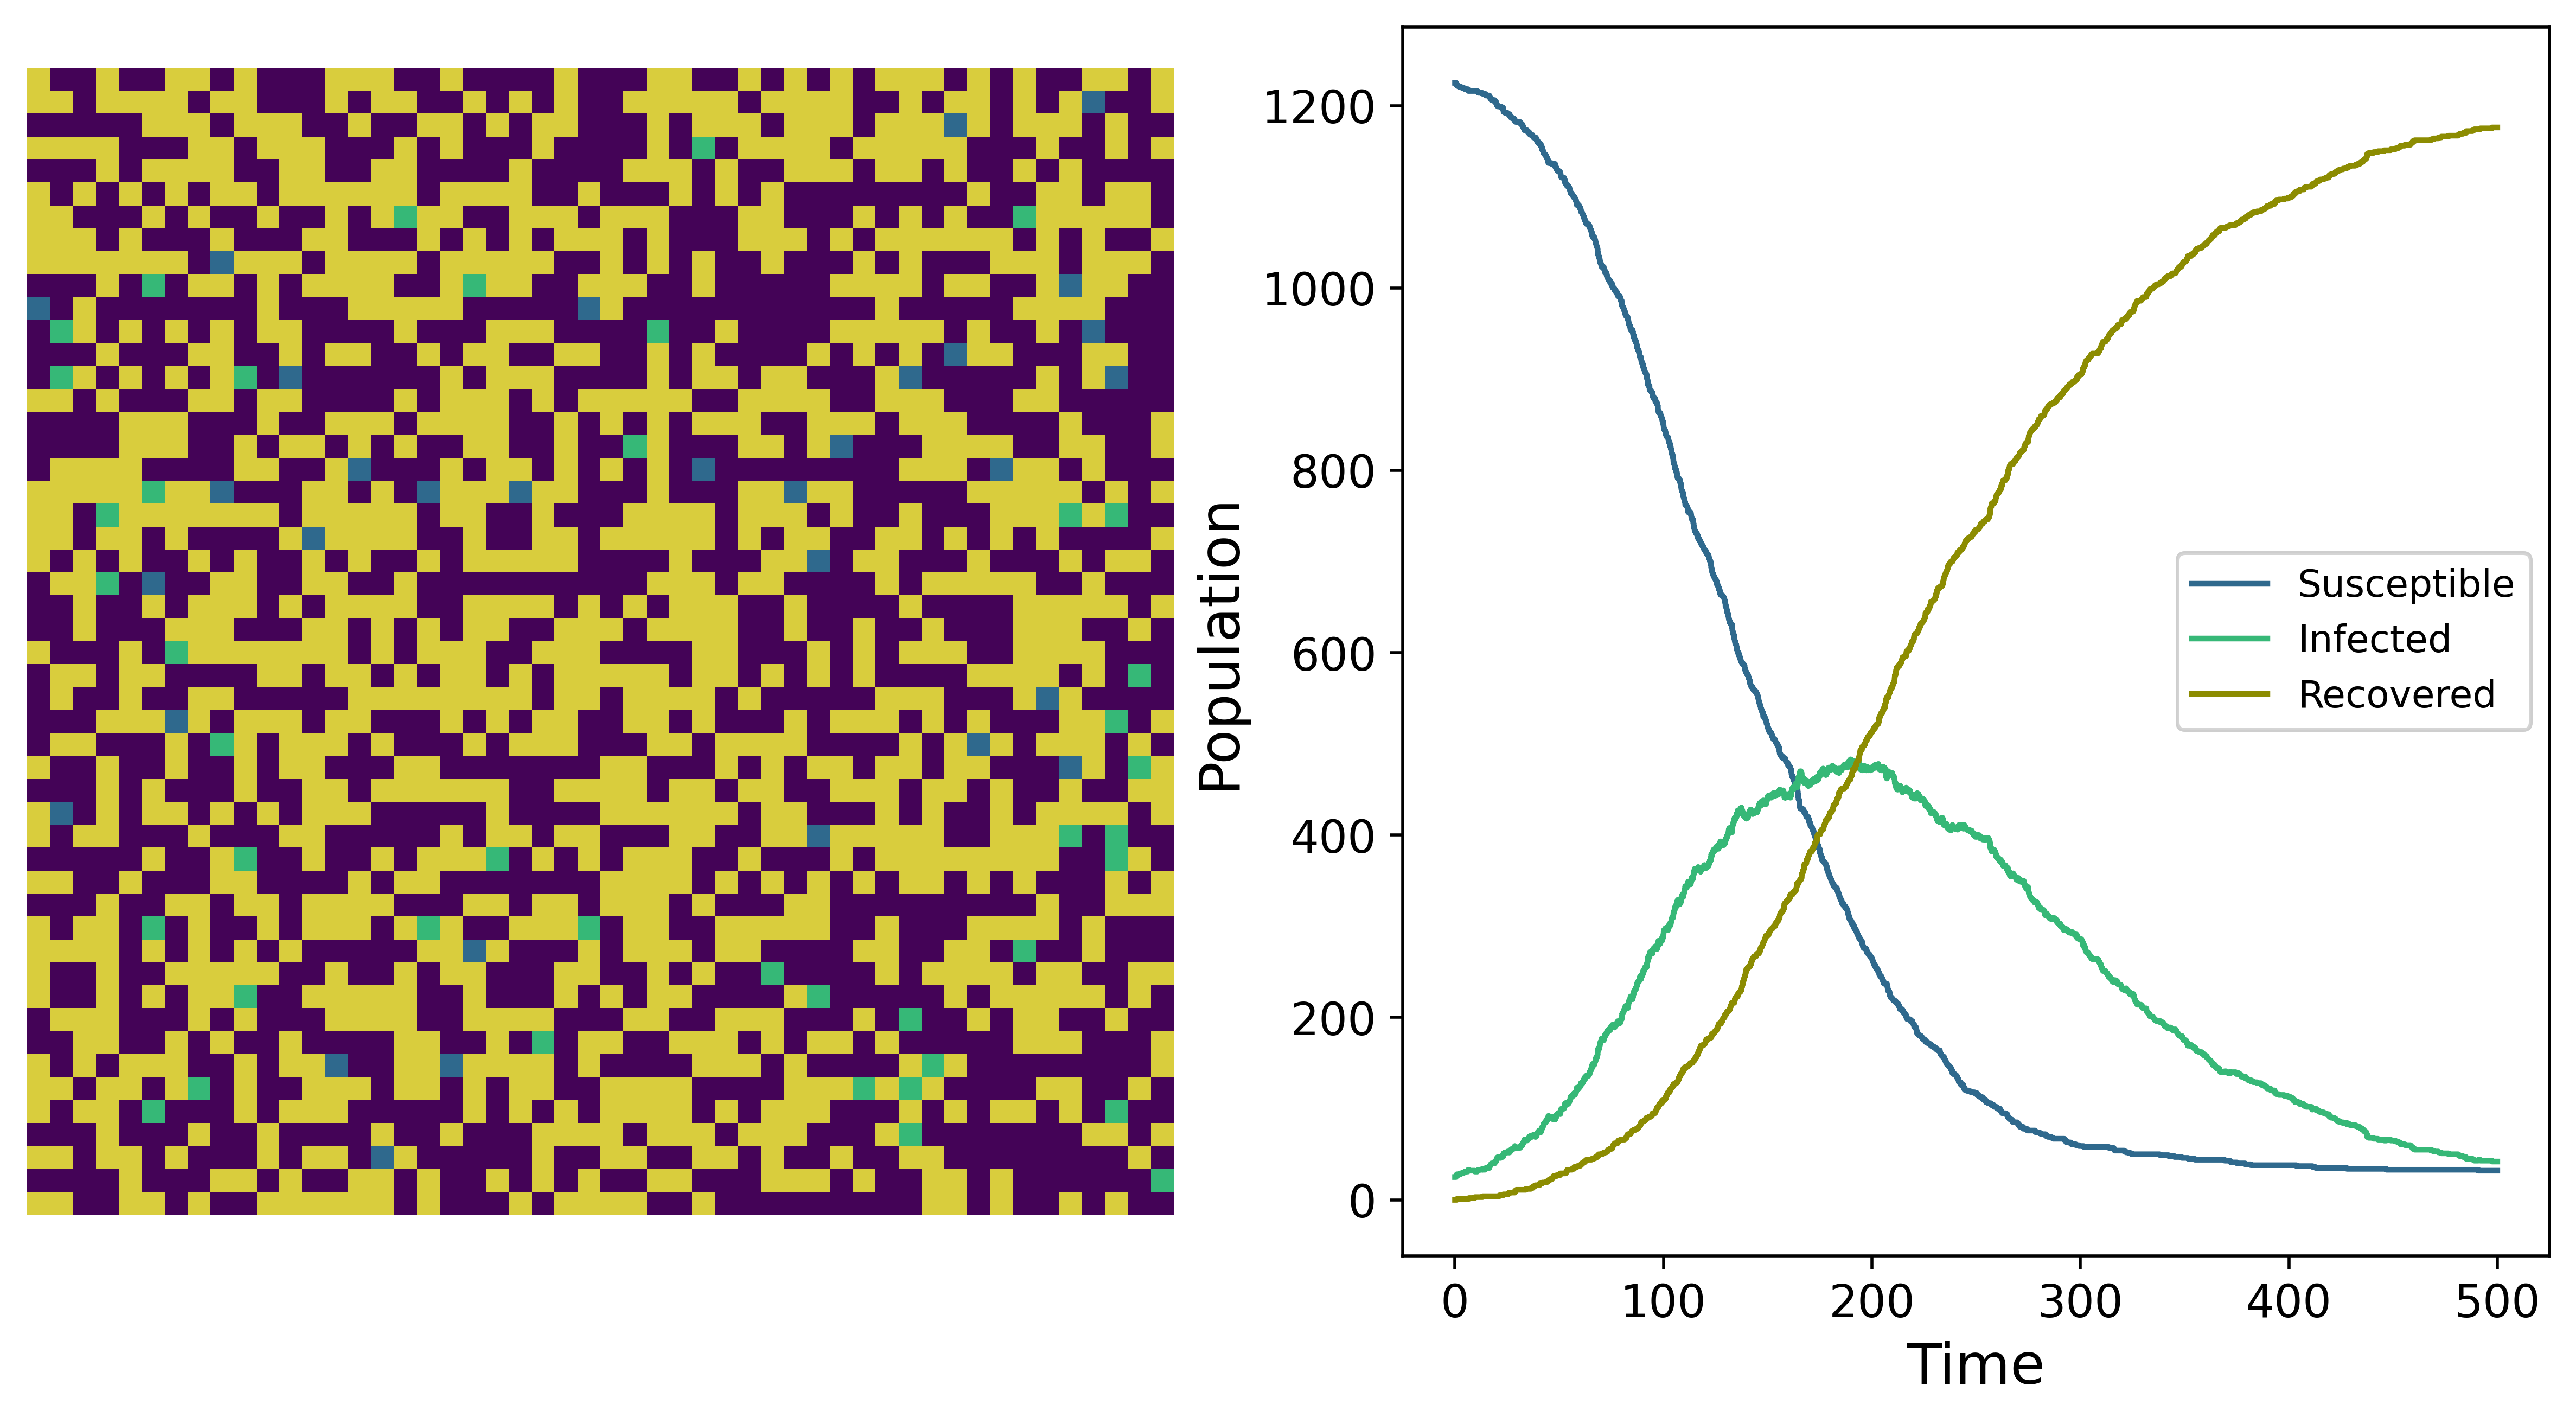

In [7]:
##anim lattice + sir graph

print("simulating")
tic = time.perf_counter()
#for large n and snapshot_num, this may take a long time. for n=15, sn=20 executes in 1min, for n=50, sn=60 executes in 40min
S, I, R, t, A_list, st = SIR_ABM(n=15, snapshot_num=20)
toc = time.perf_counter()
print(f"simulated in {toc-tic:0.4f} seconds")

print("plotting")
tic = time.perf_counter()

fig = plt.figure(figsize=(12,6), dpi=500)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.axis('off')
ax2.set_xlabel('Time', fontsize=15)
ax2.set_ylabel('Population', fontsize=15)
ax2.tick_params(axis='both', labelsize=12)
camera = Camera(fig)

for i in range(len(st)):
    print(f"plot {i} out of {len(st)}")
    if len(np.where(A_list[i]==3)[0])==0:
        cmap = colors.ListedColormap(['#440357','#2F698D','#36B877'])
    else:
        cmap = colors.ListedColormap(['#440357','#2F698D','#36B877','#d9cd3d'])
    ax1.imshow(A_list[i], cmap=cmap)

    j = st[i]
    susc, = ax2.plot(t[:j], S[:j], '#2F698D')
    inf, = ax2.plot(t[:j], I[:j], '#36B877')
    rec, = ax2.plot(t[:j], R[:j], '#8c8c01')
    ax2.legend([susc, inf, rec],['Susceptible', 'Infected', 'Recovered'])

    camera.snap()
toc = time.perf_counter()
print(f"generated plots in {toc-tic:0.4f} seconds")

print("saving")
tic = time.perf_counter()
anim = camera.animate()
anim.save('anims/test1.mp4', fps=30, progress_callback=lambda i, n: print(f'frame {i} out of {len(st)}'),)
toc = time.perf_counter()
print(f"saved in {toc-tic:0.4f} seconds")